# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

By Tom Jacobs


## Step 0: Load The Data
First, we load the train and test data from pickle files.

In [52]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']



## Step 1: Dataset Summary & Exploration

Let's take a look at the data. The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image

### Data Set Summary

In [50]:
### Data Summary

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len( set( y_train ) )

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 27839
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Data Set Visualization

Let's start with picking 48 signs out at random and displaying them along with their text labels.

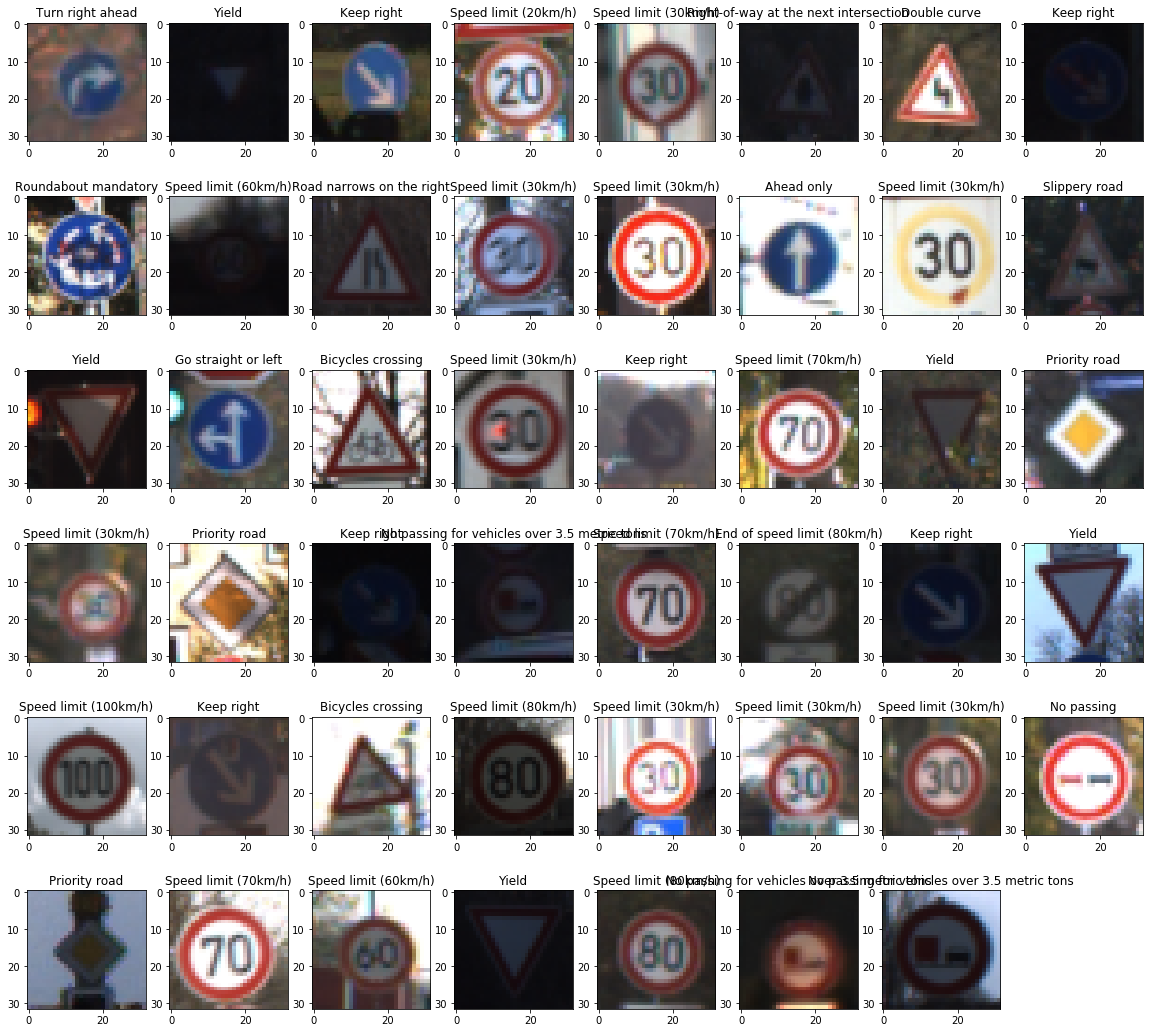

In [54]:
### Data exploration visualization
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import pandas as pd

# Read sign names
sn = pd.read_csv('./signnames.csv')

# Plot 48 signs at random
fig = plt.figure(figsize=(20,25))
for i in range(1,48):
    a = fig.add_subplot(8,8,i)
    signidx = randint(0, n_train)
    plt.imshow(X_train[signidx])
    code = int(y_train[signidx])
    plt.title( sn.iloc[code, 1] )




## Step 2: Design and Test a Model Architecture

Let's learn from this data set.

### Preprocess the Data Set (normalization, grayscale, etc.)

First, we shuffle the training data.

In [57]:
### Preprocess the data.
from sklearn.utils import shuffle

#normalization, grayscale

# Shuffle
X_train, y_train = shuffle(X_train, y_train)


### Split Data into Training, Validation and Testing Sets

In [60]:
### Split the data into training/validation sets.
from sklearn.model_selection import train_test_split

# Split. Let's say 20% of the data goes to validation.
X_train, X_validation, y_train, y_validation = train_test_split( X_train, y_train, test_size=0.2, random_state=0)


### Model Architecture
And now, we define the model architecture. Let's start of with an adapted LeNet model, and improve it from there.

In [63]:
from tensorflow.contrib.layers import flatten

# Define the model
def LeNet(x):
    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # ReLU Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # ReLU Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # ReLU Activation
    fc1    = tf.nn.relu(fc1)

    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # ReLU Activation
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    # That's it
    return logits


### Train, Validate and Test the Model

Let's train. Let's try 10 epochs, and 128 batch size. We hope for accuracy > 95%.

In [64]:
### Train
import tensorflow as tf

EPOCHS = 5
BATCH_SIZE = 128
rate = 0.001

# Inputs
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# TF Operations
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Let's save when done
saver = tf.train.Saver()

# Evaluate the model on a data set
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        # Evaluate
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.628

EPOCH 2 ...
Validation Accuracy = 0.815

EPOCH 3 ...
Validation Accuracy = 0.870

EPOCH 4 ...
Validation Accuracy = 0.897

EPOCH 5 ...
Validation Accuracy = 0.920

Model saved


## Tweaking

Nice, 92% validation accuracy.



## Test
Now that we've finished tweaking our model, let's finally run it on the test set to see how well it does.

In [80]:
with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Evaluate test data
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.815


---

## Step 3: Test a Model on New Images

To get more insight into how the model is working, I've downloaded 10 new images by screenshotting images of German traffic signs from Google Street View in Berlin and downloading from Google Image Search.

### Load and Output the Images

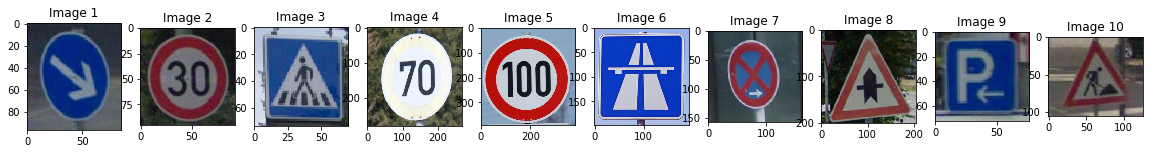

In [77]:
import cv2 as cv2
import glob

# Find and read images in test directory
filelist = glob.glob( './test/*.*' )
images = np.array([np.array(plt.imread(fname)) for fname in filelist])

# Plot 10 in a row
fig = plt.figure(figsize=(20,20))
for i in range(0,10):
    a = fig.add_subplot(1,10,i+1)
    plt.imshow(images[i])
    code = int(y_train[1])
    plt.title( "Image " + str(i+1) )

### Predict the Sign Type for Each Image

[2]


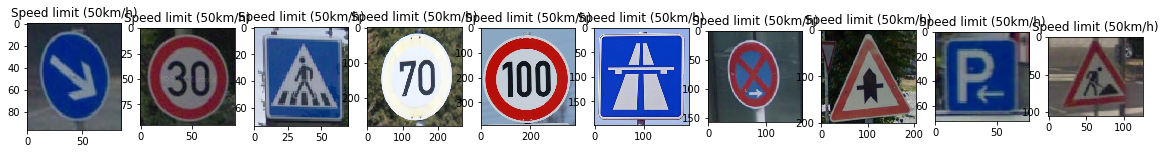

In [76]:
### Run the predictions and use the model to output the prediction for each image.
import numpy as np
import glob

#im = plt.imread('./test/test3.jpg')

# Find and read images in test directory
filelist = glob.glob( './test/*.*' )
images = np.array([np.array(plt.imread(fname)) for fname in filelist])

# Resize to 32x32 for model
#for image in images: 
#    print( image.shape )
    
#resized = cv2.resize( im, (32, 32) )
#image_list = resized[ np.newaxis, :, :, :]

# Predict with model
with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Predict
    preds = sess.run(tf.argmax(logits, 1), feed_dict={x:image_list})
    print( preds )

# Read sign names
sn = pd.read_csv('./signnames.csv')

# Plot 10 in a row
fig = plt.figure(figsize=(20,20))
for i in range(0,10):
    a = fig.add_subplot(1,10,i+1)
    plt.imshow(images[i])
    code = preds[0]
    plt.title( sn.iloc[code, 1] )
    


### Analyze Performance

In [78]:
### Calculate the accuracy for the new images. 

# What are the actual sign labels?
y_correct = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ]

# Find and read images in test directory
filelist = glob.glob( './test/*.*' )
images = np.array([np.array(plt.imread(fname)) for fname in filelist])

with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Predict
    accuracy = sess.run(accuracy_operation, feed_dict={x: images, y: y_correct})
    print( accuracy )





ValueError: setting an array element with a sequence.

### Top 5 Softmax Probabilities

Let's see how *confident* the model is on these new images. Just how sure of them are you?

In [79]:
### Print out the top five softmax probabilities

with tf.Session() as sess:
    # Load model
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    sess.run(tf.nn.top_k(tf.constant(logits), k=3))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

TypeError: Expected binary or unicode string, got <matplotlib.axes._subplots.AxesSubplot object at 0x11a70de80>

Nice, a working traffic sign classifier!

By Tom Jacobs
